读取mask权重文件

In [1]:
import os
import safetensors.torch

weight_dict = {}
for root, dir, files in os.walk("./output/xnli"):
    for file in files:
        if file.endswith(".safetensors") and "-6190" in root:
            langs = os.path.basename(os.path.dirname(root))
            path = os.path.join(root, file)
            weight_dict[langs] = safetensors.torch.load_file(path)["tensor"]
for root, dir, files in os.walk("./output/fv"):
    for file in files:
        if file.endswith(".safetensors") and "-6250" in root:
            langs = os.path.basename(os.path.dirname(root))
            path = os.path.join(root, file)
            weight_dict[langs] = safetensors.torch.load_file(path)["tensor"]
print(len(weight_dict))
for k, v in sorted(weight_dict.items()):
    print(k, v, (v.sigmoid() >= 0.5).sum().item())

78
adjective_v_verb_3 tensor([6.4547, 0.8442, 4.9701,  ..., 6.9430, 5.0350, 3.9923]) 845
ag_news tensor([ 5.5666,  2.8047,  6.6516,  ...,  9.0351,  3.7080, -5.0000]) 737
antonym tensor([ 4.6659,  4.4967,  4.5627,  ...,  7.9400,  3.3671, -5.0000]) 834
ar_de tensor([ 2.9615,  4.1869,  6.5225,  ...,  2.4945, -1.8325, -5.0000]) 909
ar_en tensor([ 1.6072,  4.0265,  5.6036,  ...,  3.5994, -1.8419, -5.0000]) 943
ar_es tensor([ 2.2431,  3.9534,  6.6193,  ..., -1.2175,  1.0918, -5.0000]) 899
ar_fr tensor([ 2.7471,  4.2052,  6.1395,  ..., -0.8100, -1.7978, -5.0000]) 908
ar_ru tensor([ 2.9796,  6.1852,  5.8957,  ...,  0.2309, -1.8855, -5.0000]) 888
ar_zh tensor([ 3.4705,  5.7370,  4.7838,  ...,  8.4880, -1.8275, -5.0000]) 885
capitalize tensor([ 5.4693,  3.4210,  4.0721,  ...,  7.2168,  3.9582, -5.0000]) 895
capitalize_first_letter tensor([ 4.6625,  4.4380,  2.9572,  ..., -1.6999,  4.1964, -5.0000]) 774
capitalize_last_letter tensor([ 7.6809, -0.0142,  4.8028,  ..., -1.9091,  3.2515, -5.0000]) 75

加载模型

In [2]:
from transformers import AutoTokenizer
from models.modeling_llama import LlamaForCausalLM
from models.modeling_qwen2 import Qwen2ForCausalLM
from models.modeling_phi3 import Phi3ForCausalLM
from models.modeling_mistral import MistralForCausalLM
from peft import PeftModel
import torch
from torch import nn
DEVICE = "cuda:0"

MODEL_DIR = "~/PretrainedModels/llama-3.1-8b-instruct-hf"
model_name = os.path.basename(MODEL_DIR)
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
model = LlamaForCausalLM.from_pretrained(
    MODEL_DIR, 
    local_files_only=True, 
    device_map=DEVICE, 
    torch_dtype=torch.bfloat16,
    attn_implementation="eager",
    max_position_embeddings=2048
)
model.generation_config.pad_token_id = tokenizer.pad_token_id
n_layers = model.config.num_hidden_layers
n_heads = model.config.num_attention_heads

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

FV数据集评测

In [ ]:
TASK_DICT = {
    "lowercase_first_letter": "Output the first letter of the given word in lowercase.",
    "park-country": "Identify the country where the given national park is located.",
    "synonym": "Identify a synonym for the given word.",
    "ag_news": "Classify the given news headline into one of the categories: Business, Science, Sports, or World. Provide only the category name.",
    "word_length": "Determine the number of letters in the given word and output the count.",
    "present-past": "Convert the given verb from its present tense to its simple past tense.",
    "capitalize": "Output the given word with its first letter capitalized.",
    "landmark-country": "Identify the country where the given landmark is located.",
    "english-german": "Translate the given English word into German.",
    "sentiment": "Determine the sentiment of the given input. Output either 'positive' or 'negative'.",
    "country-capital": "What is the capital of the given country? Provide only the name of the capital.",
    "person-occupation": "Identify the occupation of the given individual.",
    "country-currency": "What is the official currency of the given country?",
    "lowercase_last_letter": "Output the last letter of the given word in lowercase.",
    "person-sport": "Identify the sport associated with the given individual.",
    "person-instrument": "Identify the musical instrument played by the given musician.",
    "antonym": "Identify the antonym of the given word.",
    "capitalize_last_letter": "Output the last letter of the given word in uppercase.",
    "english-french": "Translate the given English word into French.",
    "next_item": "What is the next sequential item following the given input?",
    "singular-plural": "Provide the plural form of the given singular noun.",
    "capitalize_second_letter": "Output the second letter of the given word in uppercase.",
    "prev_item": "What is the item that comes before the given input in a sequential context?",
    "capitalize_first_letter": "Output the first letter of the given word in uppercase.",
    "english-spanish": "Translate the given English word into Spanish.",
    "next_capital_letter": "What is the next uppercase letter in alphabetical order after the given input?",
    "national_parks": "Identify the U.S. state where the given national park is located.",
    "product-company": "Identify the company associated with the given product.",
    "conll2003_organization": "Extract the organization mentioned in the given text.",
    "conll2003_person": "Extract the name of the person mentioned in the given text.",
    "conll2003_location": "Extract the location mentioned in the given text.",
    "adjective_v_verb_3": "From the given words, identify the one that is an adjective.",
    "object_v_concept_3": "From the given words, identify the one that is a concept.",
    "verb_v_adjective_3": "From the given words, identify the one that is a verb.",
    "fruit_v_animal_3": "From the given words, identify the one that is a fruit."
}

In [ ]:
import datasets
import pandas as pd
import copy
import numpy as np
import itertools
from tqdm.notebook import tqdm

LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LLAMA_PLM_TEMPLATE = "<|begin_of_text|>{src}\n\n"
QWEN2_TEMPLATE = "<|im_start|>user\n{src}<|im_end|>\n<|im_start|>assistant\n"
QWEN2_PLM_TEMPLATE = "{src}\n\n"

if "llama" in model_name:
    if "instruct" in model_name:
        template = LLAMA_TEMPLATE
        print("using LLAMA_TEMPLATE")
    else:
        template = LLAMA_PLM_TEMPLATE
        print("using LLAMA_PLM_TEMPLATE")
elif "qwen2" in model_name:
    if "instruct" in model_name:
        template = QWEN2_TEMPLATE
        print("using QWEN2_TEMPLATE")
    else:
        template = QWEN2_PLM_TEMPLATE
        print("using QWEN2_PLM_TEMPLATE")
else:
    print("Unknown model")

dev_datasets = []
for root, dirs, files in os.walk("./dataset/function_vectors/abstractive"):
    for file in files:
        if file.endswith(".json"):
            task = os.path.basename(file).split(".")[0]
            data_path = os.path.join(root, file)
            dataset = datasets.Dataset.from_json(data_path)
            dataset = dataset.map(
                lambda sample: {
                    "input_str": task_dict[task] + f"\n\nInput:\n\n{sample['input']}\n\nOutput:\n\n",
                    "target_str": sample["output"],
                }
            )

            dataset = dataset.remove_columns(["input", "output"])
            dev_dataset = dataset.select(range(len(dataset) - 100, len(dataset)))
            dev_datasets.append((task, dev_dataset))
for task, dataset in tqdm(dev_datasets):
    correct = 0
    for sample in dataset:
        input_str, target_str = sample["input_str"], sample["target_str"]
        combined_str = template.format(src=input_str.strip())
        lm_inputs_src = tokenizer(
            combined_str, 
            max_length=2048, 
            truncation=True, 
            padding=False, 
            add_special_tokens=False,
            return_tensors="pt"
        ).to(DEVICE)

        with torch.no_grad():
            generate_ids = model.generate(**lm_inputs_src, max_new_tokens=10, weight_tensor=None, do_sample=False)
            pred_str = tokenizer.decode(generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
        if task in [
            "capitalize_first_letter", "capitalize_last_letter", "capitalize_second_letter", "capitalize", 
            "lowercase_first_letter", "lowercase_last_letter", "next_capital_letter", "next_item", "prev_item", "commonsense_qa",
            "conll2003_organization", "conll2003_person", "conll2003_location", 
            "adjective_v_verb_3", "object_v_concept_3", "verb_v_adjective_3", "fruit_v_animal_3",
        ]:
            if pred_str.strip().startswith(target_str.strip()):
                correct += 1
        else:
            if target_str.strip() in pred_str.strip():
                correct += 1
    score = correct / len(dataset)
    print(f"{task}: {score}")

  0%|          | 0/36 [00:00<?, ?it/s]

lowercase_first_letter: 0.0
park-country: 0.23
synonym: 0.01
ag_news: 0.01
word_length: 0.0
present-past: 0.08
capitalize: 0.26
landmark-country: 0.26
english-german: 0.0
sentiment: 0.1
country-capital: 0.04
person-occupation: 0.0
country-currency: 0.0
lowercase_last_letter: 0.0
person-sport: 0.05
person-instrument: 0.01
conll2003_organization: 0.03
adjective_v_verb_3: 0.21
object_v_concept_3: 0.05
verb_v_adjective_3: 0.2
antonym: 0.07
capitalize_last_letter: 0.0
english-french: 0.0
next_item: 0.01
commonsense_qa: 0.6
singular-plural: 0.08
capitalize_second_letter: 0.02
prev_item: 0.01
capitalize_first_letter: 0.01
english-spanish: 0.0
next_capital_letter: 0.03
national_parks: 0.25
product-company: 0.06
conll2003_person: 0.08
conll2003_location: 0.16
fruit_v_animal_3: 0.09


单个语言对 翻译PPL

In [ ]:
import datasets
import pandas as pd
import copy
import numpy as np
import itertools
from tqdm.notebook import tqdm

LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LLAMA_PLM_TEMPLATE = "<|begin_of_text|>{src}\n\n"

test_weight = (weight_dict["en_zh"].sigmoid() >= 0.5).float().numpy()
# en_weights = np.array([(weight_dict[lang_pair].sigmoid() >= 0.5).float().numpy() for lang_pair in weight_dict.keys() if "en" in lang_pair])
# all_weights = np.array([(weight_dict[lang_pair].sigmoid() >= 0.5).float().numpy() for lang_pair in weight_dict.keys()])
# en_common_weight = ((en_weights.sum(axis=0) == 12)).astype(float)
# all_common_weight = ((all_weights.sum(axis=0) == 42)).astype(float)
# all_empty_weight = ((all_weights.sum(axis=0) == 0)).astype(float)

LANG_LIST = ["fr", "zh"]
LANG_DICT = {"ar": "Arabic", "fr": "French", "es": "Spanish", "de": "German", "en": "English", "ru": "Russian", "zh": "Chinese"}
def _preprocess_xnli(dataset: datasets.Dataset):
    pair_datasets = []
    for src_lang, tgt_lang in itertools.combinations(LANG_LIST, 2):
        pair_dataset = dataset.map(
            lambda sample: {
                "input_str": sample[src_lang] + f"",
                "target_str": sample[tgt_lang],
            }
        ).select_columns(["input_str", "target_str"])
        pair_datasets.append(pair_dataset)
    return datasets.concatenate_datasets(pair_datasets)
dataset = datasets.Dataset.from_csv("./dataset/XNLI-15way/xnli.15way.orig.tsv", sep='\t').select_columns(LANG_LIST)
dev_dataset = dataset.select(range(len(dataset) - 100, len(dataset)))
dev_dataset = _preprocess_xnli(dev_dataset)

original_ppl, weighted_ppl, random_ppl = [], [], []
empty_ppl = []
for input_str, target_str in tqdm(zip(*dev_dataset[:100].values()), total=100):
    combined_str = LLAMA_TEMPLATE.format(src=input_str.strip()) + f"{target_str.strip()}<|eot_id|>"
    lm_inputs = tokenizer(
        combined_str, 
        max_length=2048, 
        truncation=True, 
        padding=False, 
        add_special_tokens=False,
        return_tensors="pt"
    ).to(DEVICE)
    input_str_len = tokenizer(LLAMA_TEMPLATE.format(src=input_str.strip()), add_special_tokens=False, return_tensors="pt")["input_ids"].size(-1)
    labels = copy.deepcopy(lm_inputs["input_ids"]).to(DEVICE)
    labels[:, :input_str_len] = -100

    with torch.no_grad():
        original_output = model(**lm_inputs, labels=labels)
        original_ppl.append(original_output.loss.item())

        # weights_tensor = torch.tensor(test_weight).unsqueeze(0).repeat(1, 1).to(model.device)
        # weighted_output = model(**lm_inputs, labels=labels, weight_tensor=weights_tensor)
        # weighted_ppl.append(weighted_output.loss.item())

        # random_tensor = torch.tensor(test_weight)[torch.randperm(len(en_special_weight))].unsqueeze(0).repeat(1, 1).to(model.device)
        # random_output = model(**lm_inputs, labels=labels, weight_tensor=random_tensor)
        # random_ppl.append(random_output.loss.item())

        # empty_tensor = torch.tensor(all_empty_weight).unsqueeze(0).repeat(1, 1).to(model.device)
        # empty_output = model(**lm_inputs, labels=labels, weight_tensor=empty_tensor)
        # empty_ppl.append(empty_output.loss.item())

print("Original PPL", np.nanmean(original_ppl))
print("Weighted PPL", np.nanmean(weighted_ppl))
print("Random PPL", np.nanmean(random_ppl))
print("Empty PPL", np.nanmean(empty_ppl))

  0%|          | 0/100 [00:00<?, ?it/s]

Original PPL 1.0920265451073647
Weighted PPL nan
Random PPL nan
Empty PPL nan


/tmp/ipykernel_49031/2950914418.py:69: RuntimeWarning: Mean of empty slice
  print("Weighted PPL", np.nanmean(weighted_ppl))
/tmp/ipykernel_49031/2950914418.py:70: RuntimeWarning: Mean of empty slice
  print("Random PPL", np.nanmean(random_ppl))
/tmp/ipykernel_49031/2950914418.py:71: RuntimeWarning: Mean of empty slice
  print("Empty PPL", np.nanmean(empty_ppl))


全语言PPL

In [4]:
import datasets
import pandas as pd
import copy
import numpy as np
import itertools
from tqdm.notebook import tqdm
from IPython.display import display

LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LLAMA_PLM_TEMPLATE = "<|begin_of_text|>{src}\n\n"
QWEN2_TEMPLATE = "<|im_start|>user\n{src}<|im_end|>\n<|im_start|>assistant\n"
QWEN2_PLM_TEMPLATE = "{src}\n\n"
PHI3_TEMPLATE = "<|user|>\n{src}<|end|>\n<|assistant|>\n"
MISTRAL_TEMPLATE = "<s>[INST] {src}[/INST]"

LANG_LIST = ["en", "zh", "fr", "es", "de", "ru", "ar"]
LANG_DICT = {"ar": "Arabic", "fr": "French", "es": "Spanish", "de": "German", "en": "English", "ru": "Russian", "zh": "Chinese"}
dataset = datasets.Dataset.from_csv("./dataset/XNLI-15way/xnli.15way.orig.tsv", sep='\t').select_columns(LANG_LIST)
dataset = dataset.select(range(len(dataset) - 100, len(dataset)))

langs_original_ppl, langs_weighted_ppl = {}, {}
for src_lang, tgt_lang in tqdm(list(itertools.permutations(LANG_LIST, 2))):
    test_weight = (weight_dict[f"{src_lang}_{tgt_lang}"].sigmoid() >= 0.5).float().numpy()
    # mask = np.zeros_like(test_weight, dtype=bool)
    # mask[np.arange(32, 1056, 33)] = True
    # random_weight = test_weight[~mask]
    # np.random.shuffle(random_weight)
    # test_weight[~mask] = random_weight

    dev_dataset = dataset.map(
        lambda sample: {
            "input_str": sample[src_lang] + f"",
            "target_str": sample[tgt_lang],
        }
    ).select_columns(["input_str", "target_str"])

    if src_lang not in langs_original_ppl:
        langs_original_ppl[src_lang] = {src_lang: 0}
    if src_lang not in langs_weighted_ppl:
        langs_weighted_ppl[src_lang] = {src_lang: 0}
    original_ppl, weighted_ppl = [], []
    for input_str, target_str in zip(*dev_dataset[:100].values()):
        combined_str = MISTRAL_TEMPLATE.format(src=input_str.strip()) + f" {target_str.strip()}</s>"
        lm_inputs = tokenizer(
            combined_str, 
            max_length=2048, 
            truncation=True, 
            padding=False, 
            add_special_tokens=False,
            return_tensors="pt"
        ).to(DEVICE)
        input_str_len = tokenizer(MISTRAL_TEMPLATE.format(src=input_str.strip()), add_special_tokens=False, return_tensors="pt")["input_ids"].size(-1)
        labels = copy.deepcopy(lm_inputs["input_ids"]).to(DEVICE)
        labels[:, :input_str_len] = -100

        with torch.no_grad():
            original_output = model(**lm_inputs, labels=labels)
            original_ppl.append(original_output.loss.item())

            weights_tensor = torch.tensor(test_weight).unsqueeze(0).repeat(1, 1).to(model.device)
            weighted_output = model(**lm_inputs, labels=labels, weight_tensor=weights_tensor)
            weighted_ppl.append(weighted_output.loss.item())
    langs_original_ppl[src_lang][tgt_lang] = np.nanmean(original_ppl)
    langs_weighted_ppl[src_lang][tgt_lang] = np.nanmean(weighted_ppl)
original_df = pd.DataFrame.from_dict(langs_original_ppl, orient="index")
display(original_df)
weighted_df = pd.DataFrame.from_dict(langs_weighted_ppl, orient="index")
display(weighted_df)

  0%|          | 0/42 [00:00<?, ?it/s]

,en,zh,fr,es,de,ru,ar
en,0.000000,3.667306,3.031928,3.264336,3.332856,2.820511,2.381085
zh,4.456821,0.000000,3.174475,3.260641,3.512219,3.013937,2.184349
fr,3.438435,3.117786,0.000000,2.862730,3.031887,2.516917,2.163149
es,3.579157,3.189549,2.786711,0.000000,3.026272,2.569668,2.139962
de,3.459557,3.328962,2.649787,2.791191,0.000000,2.482695,2.265096
ru,4.512157,3.551286,2.930834,3.186088,3.204075,0.000000,2.207280
ar,4.303690,3.551452,3.076920,3.314841,3.527168,2.981320,0.000000


,en,zh,fr,es,de,ru,ar
en,0.000000,3.275061,2.439838,3.540062,2.523919,2.853929,2.654218
zh,2.914419,0.000000,3.605471,3.063491,3.274683,3.169648,2.539706
fr,3.518316,3.337823,0.000000,2.247834,3.562074,2.744232,2.060642
es,2.376545,3.158847,4.525475,0.000000,3.784137,2.572364,2.358379
de,2.473774,4.737382,2.719880,3.607627,0.000000,2.943579,2.827967
ru,3.546505,4.553660,3.442206,3.491933,4.709808,0.000000,2.915890
ar,3.349108,4.378305,5.172326,3.781758,3.961613,3.509712,0.000000


全语言ROUGE

In [5]:
import datasets
import pandas as pd
import copy
import numpy as np
import itertools
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LLAMA_PLM_TEMPLATE = "<|begin_of_text|>{src}\n\n"
QWEN2_TEMPLATE = "<|im_start|>user\n{src}<|im_end|>\n<|im_start|>assistant\n"
QWEN2_PLM_TEMPLATE = "{src}\n\n"
MISTRAL_TEMPLATE = "<s>[INST] {src}[/INST]"
PHI3_TEMPLATE = "<|user|>\n{src}<|end|>\n<|assistant|>\n"
LANG_LIST = ["en", "zh", "fr", "es", "de", "ru", "ar"]
LANG_DICT = {"ar": "Arabic", "fr": "French", "es": "Spanish", "de": "German", "en": "English", "ru": "Russian", "zh": "Chinese"}
dataset = datasets.Dataset.from_csv("./dataset/XNLI-15way/xnli.15way.orig.tsv", sep='\t').select_columns(LANG_LIST)
dataset = dataset.select(range(len(dataset) - 100, len(dataset)))

sentence_tokenizer = AutoTokenizer.from_pretrained("~/PretrainedModels/bge-m3", use_fast=True)
rouge_scorer_instance = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True, tokenizer=sentence_tokenizer)
langs_original_rouge, langs_weighted_rouge = {}, {}
for src_lang, tgt_lang in tqdm(list(itertools.permutations(LANG_LIST, 2))[:12]):    # en- and zh-
    test_weight = (weight_dict[f"{src_lang}_{tgt_lang}"].sigmoid() >= 0.5).float().numpy().clip(min=0.3)

    dev_dataset = dataset.map(
        lambda sample: {
            "input_str": sample[src_lang] + f"\n\nTranslate into {LANG_DICT[tgt_lang]}:",
            "target_str": sample[tgt_lang],
        }
    ).select_columns(["input_str", "target_str"])

    if src_lang not in langs_original_rouge:
        langs_original_rouge[src_lang] = {src_lang: 0}
    if src_lang not in langs_weighted_rouge:
        langs_weighted_rouge[src_lang] = {src_lang: 0}
    original_rouge, weighted_rouge = [], []
    for input_str, target_str in zip(*dev_dataset[:100].values()):
        combined_str = LLAMA_TEMPLATE.format(src=input_str.strip())
        lm_inputs_src = tokenizer(
            combined_str, 
            max_length=2048, 
            truncation=True, 
            padding=False, 
            add_special_tokens=False,
            return_tensors="pt"
        ).to(DEVICE)

        with torch.no_grad():
            original_generate_ids = model.generate(**lm_inputs_src, max_new_tokens=50, weight_tensor=None, do_sample=False)
            original_pred_str = tokenizer.decode(original_generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
            original_rouge_scores = rouge_scorer_instance.score(original_pred_str, target_str)
            original_rouge_l = original_rouge_scores["rougeL"].fmeasure
            original_rouge.append(original_rouge_l)

            weights_tensor = torch.tensor(test_weight).unsqueeze(0).repeat(1, 1).to(model.device)
            weighted_generate_ids = model.generate(**lm_inputs_src, max_new_tokens=50, weight_tensor=weights_tensor, do_sample=False)
            weighted_pred_str = tokenizer.decode(weighted_generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
            weighted_rouge_scores = rouge_scorer_instance.score(weighted_pred_str, target_str)
            weighted_rouge_l = weighted_rouge_scores["rougeL"].fmeasure
            weighted_rouge.append(weighted_rouge_l)

    langs_original_rouge[src_lang][tgt_lang] = np.nanmean(original_rouge)
    langs_weighted_rouge[src_lang][tgt_lang] = np.nanmean(weighted_rouge)
original_df = pd.DataFrame.from_dict(langs_original_rouge, orient="index")
display(original_df)
weighted_df = pd.DataFrame.from_dict(langs_weighted_rouge, orient="index")
display(weighted_df)

  0%|          | 0/12 [00:00<?, ?it/s]

~/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
~/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/tmp/ipykernel_56474/3687064272.py:77: RuntimeWarning: Mean of empty slice
  langs_original_rouge[src_lang][tgt_lang] = np.nanmean(original_rouge)


,en,zh,fr,es,de,ru,ar
en,0.0,NaN,NaN,NaN,NaN,NaN,NaN
zh,NaN,0.0,NaN,NaN,NaN,NaN,NaN


,en,zh,fr,es,de,ru,ar
en,0.000000,0.602289,0.706699,0.755971,0.659001,0.489092,0.462009
zh,0.660609,0.000000,0.544042,0.547754,0.499999,0.419475,0.364882


缩小mask之外的注意力头的输出

In [5]:
import datasets
import pandas as pd
import copy
import numpy as np
import itertools
from tqdm.notebook import tqdm

LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LLAMA_PLM_TEMPLATE = "<|begin_of_text|>{src}\n\n"
QWEN2_TEMPLATE = "<|im_start|>user\n{src}<|im_end|>\n<|im_start|>assistant\n"
QWEN2_PLM_TEMPLATE = "{src}\n\n"
MISTRAL_TEMPLATE = "<s>[INST] {src}[/INST]"
PHI3_TEMPLATE = "<|user|>\n{src}<|end|>\n<|assistant|>\n"
LANG_LIST = ["en", "zh", "fr", "es", "de", "ru", "ar"]
LANG_DICT = {"ar": "Arabic", "fr": "French", "es": "Spanish", "de": "German", "en": "English", "ru": "Russian", "zh": "Chinese"}
dataset = datasets.Dataset.from_csv("./dataset/XNLI-15way/xnli.15way.orig.tsv", sep='\t').select_columns(LANG_LIST)
dataset = dataset.select(range(len(dataset) - 100, len(dataset)))

langs_weighted_ppl = {}
lang_pairs = [("en", "zh"), ("zh", "en"), ("en", "fr"), ("fr", "en"), ("en", "de"), ("de", "en")]
for src_lang, tgt_lang in tqdm(lang_pairs):
    dev_dataset = dataset.map(
        lambda sample: {
            "input_str": sample[src_lang] + f"\n\nTranslate into {LANG_DICT[tgt_lang]}:",
            "target_str": sample[tgt_lang],
        }
    ).select_columns(["input_str", "target_str"])

    weighted_ppl = {v: [] for v in np.arange(0, 1.1, 0.1)}
    for input_str, target_str in tqdm(zip(*dev_dataset[:100].values()), total=100):
        combined_str = LLAMA_TEMPLATE.format(src=input_str.strip()) + f"{target_str.strip()}<|eot_id|>"
        lm_inputs = tokenizer(
            combined_str, 
            max_length=2048, 
            truncation=True, 
            padding=False, 
            add_special_tokens=False,
            return_tensors="pt"
        ).to(DEVICE)
        input_str_len = tokenizer(LLAMA_TEMPLATE.format(src=input_str.strip()), add_special_tokens=False, return_tensors="pt")["input_ids"].size(-1)
        labels = copy.deepcopy(lm_inputs["input_ids"]).to(DEVICE)
        labels[:, :input_str_len] = -100

        with torch.no_grad():
            for min_weight in np.arange(0, 1.1, 0.1):
                test_weight = (weight_dict[f"en_fr"].sigmoid() >= 0.5).float().numpy().clip(min=min_weight)
                weights_tensor = torch.tensor(test_weight).unsqueeze(0).repeat(1, 1).to(model.device)
                weighted_output = model(**lm_inputs, labels=labels, weight_tensor=weights_tensor)
                weighted_ppl[min_weight].append(weighted_output.loss.item())
    weighted_ppl = {k: np.nanmean(weighted_ppl[k]) for k in weighted_ppl}
    langs_weighted_ppl[f"{src_lang}_{tgt_lang}"] = weighted_ppl
df = pd.DataFrame.from_dict(langs_weighted_ppl, orient="index")
display(df)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

The dtype of the weight_tensor is different from the dtype of the model parameters (Expected torch.bfloat16, Got torch.float64). Converting the weight_tensor to torch.bfloat16.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
en_zh,1.052758,1.046026,1.046039,1.049787,1.054194,1.057938,1.064922,1.068002,1.074555,1.081020,1.091267
zh_en,1.269545,1.169950,1.096675,1.048448,1.020125,1.004074,0.994633,0.991196,0.991588,0.995453,1.002608
en_fr,0.545311,0.540531,0.538572,0.539228,0.543299,0.549582,0.558028,0.568524,0.581022,0.598897,0.618853
fr_en,1.042092,0.927280,0.863180,0.822292,0.795706,0.778070,0.764933,0.757192,0.752688,0.754021,0.756403
en_de,0.633055,0.576405,0.561894,0.555955,0.555985,0.559190,0.566885,0.578243,0.590663,0.606252,0.627102
de_en,0.932956,0.791802,0.728101,0.695594,0.670347,0.649085,0.637272,0.630361,0.627818,0.628392,0.629095


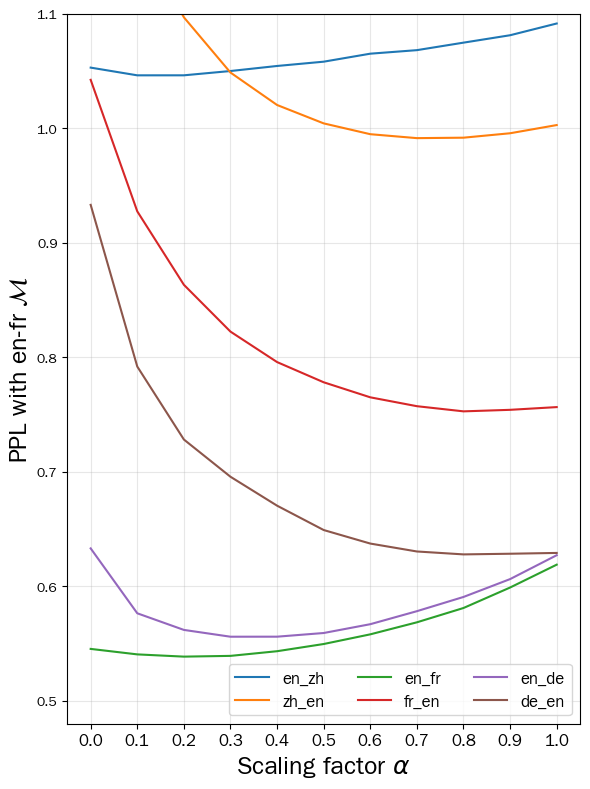

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ["WenQuanYi Zen Hei"]
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
colors = sns.color_palette(n_colors=6)

plt.figure(figsize=(6, 8))
plt.ylim(0.48, 1.1)
plt.xticks(np.arange(0, 1.1, 0.1), fontsize=12)
plt.xlabel(r"Scaling factor $\alpha$", fontsize=18)
plt.ylabel(r"PPL with en-fr $\mathcal{M}$", fontsize=18)
# plt.yticks(fontsize=12)
maskonly_ppl = {
    "en_fr": 0.551806, "en_de": 0.580341, "en_zh": 1.016755,
    "fr_en": 0.734948, "de_en": 0.638766, "zh_en": 0.997446
}
for i, (lang_pair, values) in enumerate(df.iterrows()):
    plt.plot(np.arange(0, 1.1, 0.1), values, linestyle='-', label=lang_pair, c=colors[i])
    # plt.plot(0, maskonly_ppl[lang_pair], marker="x", c=colors[i])
plt.grid(alpha=0.3)
plt.legend(ncol=3, fontsize=12, loc="lower right")
plt.tight_layout()
plt.savefig("figs/finding3-ppl-en_fr.pdf", dpi=150)
plt.show()

vs_3任务注意力分布

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ["WenQuanYi Zen Hei"]
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
from IPython.display import display
LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LLAMA_PLM_TEMPLATE = "<|begin_of_text|>{src}\n\n"

dev_datasets = []
for root, dirs, files in os.walk("./dataset/function_vectors/abstractive"):
    for file in files:
        if file.endswith(".json"):
            task = os.path.basename(file).split(".")[0]
            if "_v_" not in task: continue
            data_path = os.path.join(root, file)
            dataset = datasets.Dataset.from_json(data_path)
            dataset = dataset.map(
                lambda sample: {
                    "input_str": sample["input"],
                    "target_str": sample["output"],
                }
            )
            dataset = dataset.remove_columns(["input", "output"])
            dev_dataset = dataset.select(range(len(dataset) - 100, len(dataset)))
            dev_datasets.append((task, dev_dataset))

def find_segments_(l):
    indices_271 = [i for i, x in enumerate(l) if x == 271]
    start, end = indices_271[0], indices_271[1]
    segment = l[start + 1:end]

    segments = []
    current_segment = []
    for idx, value in enumerate(segment, start=start + 1):
        if value == 11:
            if current_segment:
                segments.append(current_segment)
                current_segment = []
        else:
            current_segment.append(idx)
    if current_segment:
        segments.append(current_segment)
    
    return segments

task_attentions = {}
for task, dataset in tqdm(dev_datasets):
    test_weight = (weight_dict[task].sigmoid() >= 0.5).float().numpy()
    test_tensor = torch.tensor(test_weight).unsqueeze(0).repeat(1, 1).to(model.device)
    choose_the, choose_from = task.split("_v_")[0], task.split("_v_")[1][:-2]
    instructed_attn, used_attn, unused_attn = [], [], []
    for sample in dataset:
        target_choice_idx = sample["input_str"].split(", ").index(sample["target_str"])
        input_inst_str = f"{sample['input_str']}\n\nChoose the {choose_the} out of {choose_from}s:"
        input_str = f"{sample['input_str']}"
        lm_inputs_inst_src = tokenizer([LLAMA_TEMPLATE.format(src=input_inst_str)], add_special_tokens=False, return_tensors="pt").to(DEVICE)
        lm_inputs_inst_src_choice_idx = find_segments_(lm_inputs_inst_src.input_ids[0].tolist())
        assert len(lm_inputs_inst_src_choice_idx) == 3
        lm_inputs_src = tokenizer([LLAMA_TEMPLATE.format(src=input_str)], add_special_tokens=False, return_tensors="pt").to(DEVICE)
        lm_inputs_src_choice_idx = lm_inputs_inst_src_choice_idx

        with torch.no_grad():
            original_output = model(**lm_inputs_inst_src, weight_tensor=None, output_attentions=True)
            original_attention = torch.stack(original_output.attentions)  # (n_layers, bsz, n_heads, seq_len, seq_len)
            last_token_attn = original_attention[:, -1, :, -1]
            original_token_attention = last_token_attn.mean(dim=(0,1)).float().cpu().numpy()
            original_choice_attentions = [original_token_attention[lm_inputs_inst_src_choice_idx[i]].sum() for i in range(3)]
            original_choice_attentions = np.array(original_choice_attentions) / sum(original_choice_attentions)
            instructed_attn.append(original_choice_attentions[target_choice_idx])

            weighted_output = model(**lm_inputs_src, weight_tensor=test_tensor, output_attentions=True)
            weighted_attention = torch.stack(weighted_output.attentions)  # (n_layers, bsz, n_heads, seq_len, seq_len)
            last_token_attn = weighted_attention[:, -1, :, -1]
            last_token_attn[test_tensor.view(32,33)[:, :-1] == 0] = 0
            layer_head_num = (test_tensor.view(32,33)[:, :-1] != 0).sum(dim=1)
            weighted_token_attention = (last_token_attn.sum(dim=(0,1)) / (test_tensor.sum() - 32)).float().cpu().numpy()
            weighted_choice_attentions = [weighted_token_attention[lm_inputs_src_choice_idx[i]].sum() for i in range(3)]
            weighted_choice_attentions = np.array(weighted_choice_attentions) / sum(weighted_choice_attentions)
            used_attn.append(weighted_choice_attentions[target_choice_idx])

            weighted_output = model(**lm_inputs_src, weight_tensor=test_tensor, output_attentions=True)
            weighted_attention = torch.stack(weighted_output.attentions)  # (n_layers, bsz, n_heads, seq_len, seq_len)
            last_token_unused_attn = weighted_attention[:, -1, :, -1]
            last_token_unused_attn[test_tensor.view(32,33)[:, :-1] == 1] = 0
            weighted_token_unused_attention = (last_token_unused_attn.sum(dim=(0,1)) / (1056 - test_tensor.sum())).float().cpu().numpy()
            weighted_choice_unused_attentions = [weighted_token_unused_attention[lm_inputs_src_choice_idx[i]].sum() for i in range(3)]
            weighted_choice_unused_attentions = np.array(weighted_choice_unused_attentions) / sum(weighted_choice_unused_attentions)
            unused_attn.append(weighted_choice_unused_attentions[target_choice_idx])
    task_attentions[task] = {
        "Instructed" : np.mean(instructed_attn),
        "Used": np.mean(used_attn),
        "Ununsed": np.mean(unused_attn)
    }
df = pd.DataFrame.from_dict(task_attentions, orient="index")
display(df)

  0%|          | 0/4 [00:00<?, ?it/s]

,Instructed,Used,Ununsed
adjective_v_verb_3,0.408563,0.462195,0.483597
object_v_concept_3,0.363040,0.470688,0.537032
verb_v_adjective_3,0.345372,0.426140,0.379153
fruit_v_animal_3,0.468406,0.565780,0.606870


IWSLT2017翻译生成评测

In [4]:
import datasets
import pandas as pd
import copy
import jieba
import re
import numpy as np
import itertools
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LANG_DICT = {"fr": "French", "de": "German", "en": "English", "zh": "Chinese"}
LANGPAIR_MIN = {"en_de": 0.3, "en_fr": 0.2, "en_zh": 0.1, "zh_en": 0.3, "fr_en": 0.2, "de_en": 0.4}

langs_original_bleu, langs_weighted_bleu = {}, {}
smoothing = SmoothingFunction().method1
# from OpenCompass
def general_postprocess(text: str) -> str:
    # Remove instructions
    answer_text = text.split("\n\n")
    if len(answer_text) > 2:
        answer_text = answer_text[1:2]
    elif len(answer_text) > 1:
        answer_text = answer_text[1:]
    answer_text = "\n\n".join(answer_text)
    # Cut off the first newline, period, or comma
    # truncated_text = re.split(r'[\n.,]', answer_text, 1)[0]
    # Remove punctuation
    no_punctuation = re.sub(r'[^\w\s]', '', answer_text)
    # Remove article
    # no_articles = re.sub(r'\b(a|an|the)\b',
    #                      '',
    #                      no_punctuation,
    #                      flags=re.IGNORECASE)
    # Remove duplicated blank spaces
    cleaned_text = re.sub(r'\s+', ' ', no_punctuation).strip()
    cleaned_text = " ".join(jieba.cut(cleaned_text))

    return cleaned_text

def postprocess_and_score(text: str, target_str: str):
    # Remove instructions
    answer_text = text.split("\n\n")
    cleaned_texts = [" ".join(jieba.cut(re.sub(r'\s+', ' ', re.sub(r'[^\w\s]', '', t)).strip())) for t in answer_text]
    scores = [sentence_bleu([target_str], t, smoothing_function=smoothing) for t in cleaned_texts]
    return max(zip(cleaned_texts, scores), key=lambda x: x[1])

for src_lang, tgt_lang in [("en", "de"), ("en", "fr"), ("de", "en"), ("fr", "en"), ("en", "zh"), ("zh", "en")]:
    if tgt_lang != "en":
        dev_dataset = datasets.Dataset.from_parquet(f"./dataset/iwslt2017/{src_lang}-{tgt_lang}-test.parquet")
    else:
        dev_dataset = datasets.Dataset.from_parquet(f"./dataset/iwslt2017/{tgt_lang}-{src_lang}-test.parquet")
    dev_dataset = dev_dataset.map(
        lambda sample: {
            "input_str": f"{sample['translation'][src_lang]}\n\nTranslate into {tgt_lang}:",
            "target_str": sample['translation'][tgt_lang],
        }
    ).select_columns(["input_str", "target_str"])

    test_weight = (weight_dict[f"{src_lang}_{tgt_lang}"].sigmoid() >= 0.5).float().numpy().clip(min=LANGPAIR_MIN[f"{src_lang}_{tgt_lang}"])
    original_bleu, weighted_bleu = [], []
    for sample in tqdm(dev_dataset):
        input_str, target_str = sample["input_str"], sample["target_str"]
        target_str = general_postprocess(target_str)
        combined_str = LLAMA_TEMPLATE.format(src=input_str.strip())
        lm_inputs_src = tokenizer(
            combined_str, 
            max_length=2048, 
            truncation=True, 
            padding=False, 
            add_special_tokens=False,
            return_tensors="pt"
        ).to(DEVICE)

        with torch.no_grad():
            original_generate_ids = model.generate(**lm_inputs_src, max_new_tokens=50, weight_tensor=None, do_sample=False)
            original_pred_str = tokenizer.decode(original_generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
            original_pred_str, original_bleu4 = postprocess_and_score(original_pred_str, target_str)
            original_bleu.append(original_bleu4)

            weights_tensor = torch.tensor(test_weight).unsqueeze(0).repeat(1, 1).to(model.device)
            weighted_generate_ids = model.generate(**lm_inputs_src, max_new_tokens=50, weight_tensor=weights_tensor, do_sample=False)
            weighted_pred_str = tokenizer.decode(weighted_generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
            weighted_pred_str, weighted_bleu4 = postprocess_and_score(weighted_pred_str, target_str)
            weighted_bleu.append(weighted_bleu4)
            pass

    langs_original_bleu[f"{src_lang}_{tgt_lang}"] = np.nanmean(original_bleu)
    langs_weighted_bleu[f"{src_lang}_{tgt_lang}"] = np.nanmean(weighted_bleu)
    print(f"{src_lang}_{tgt_lang}: {np.nanmean(original_bleu)} {np.nanmean(weighted_bleu)}")
original_df = pd.DataFrame.from_dict(langs_original_bleu, orient="index")
display(original_df)
weighted_df = pd.DataFrame.from_dict(langs_weighted_bleu, orient="index")
display(weighted_df)

  0%|          | 0/8079 [00:00<?, ?it/s]

The dtype of the weight_tensor is different from the dtype of the model parameters (Expected torch.bfloat16, Got torch.float32). Converting the weight_tensor to torch.bfloat16.


en_de: 0.5518987329983651 0.5571285020780189


  0%|          | 0/8597 [00:00<?, ?it/s]

en_fr: 0.7055008235863013 0.716728104947645


  0%|          | 0/8079 [00:00<?, ?it/s]

de_en: 0.7153259589899276 0.7232331679209235


  0%|          | 0/8597 [00:00<?, ?it/s]

fr_en: 0.7189587757660194 0.7489482864525915


  0%|          | 0/8549 [00:00<?, ?it/s]

en_zh: 0.3142911036430604 0.348499569073858


  0%|          | 0/8549 [00:00<?, ?it/s]

zh_en: 0.6083390239142678 0.6141746436241875


,0
en_de,0.551899
en_fr,0.705501
de_en,0.715326
fr_en,0.718959
en_zh,0.314291
zh_en,0.608339


,0
en_de,0.557129
en_fr,0.716728
de_en,0.723233
fr_en,0.748948
en_zh,0.348500
zh_en,0.614175


比较输出差异

In [3]:
import datasets
import pandas as pd
import copy
import numpy as np
import itertools
from tqdm.notebook import tqdm
from rouge_score import rouge_scorer

LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LLAMA_PLM_TEMPLATE = "<|begin_of_text|>{src}\n\n"
QWEN2_TEMPLATE = "<|im_start|>user\n{src}<|im_end|>\n<|im_start|>assistant\n"
QWEN2_PLM_TEMPLATE = "{src}\n\n"
MISTRAL_TEMPLATE = "<s>[INST] {src}[/INST]"
PHI3_TEMPLATE = "<|user|>\n{src}<|end|>\n<|assistant|>\n"
LANG_LIST = ["en", "zh", "fr", "es", "de", "ru", "ar"]
LANG_DICT = {"ar": "Arabic", "fr": "French", "es": "Spanish", "de": "German", "en": "English", "ru": "Russian", "zh": "Chinese"}
dataset = datasets.Dataset.from_csv("./dataset/XNLI-15way/xnli.15way.orig.tsv", sep='\t').select_columns(LANG_LIST)
dataset = dataset.select(range(len(dataset) - 100, len(dataset)))

src_lang, tgt_lang = "zh", "en"
test_weight = (weight_dict[f"{src_lang}_{tgt_lang}"].sigmoid() >= 0.5).float().numpy().clip(min=0)
dev_dataset = dataset.map(
    lambda sample: {
        "input_str": sample[src_lang],
        "target_str": sample[tgt_lang],
    }
).select_columns(["input_str", "target_str"])
golds, original_preds, weighted_preds = [], [], []
for input_str, target_str in tqdm(zip(*dev_dataset[:100].values()), total=100):
    combined_str_inst = QWEN2_TEMPLATE.format(src=input_str.strip() + f"\n\nTranslate into {LANG_DICT[tgt_lang]}:")
    lm_inputs_src_inst = tokenizer(
        combined_str_inst, 
        max_length=2048, 
        truncation=True, 
        padding=False, 
        add_special_tokens=False,
        return_tensors="pt"
    ).to(DEVICE)
    combined_str = QWEN2_TEMPLATE.format(src=input_str.strip())
    lm_inputs_src = tokenizer(
        combined_str, 
        max_length=2048, 
        truncation=True, 
        padding=False, 
        add_special_tokens=False,
        return_tensors="pt"
    ).to(DEVICE)

    golds.append(target_str)
    with torch.no_grad():
        original_generate_ids = model.generate(**lm_inputs_src_inst, max_new_tokens=50, weight_tensor=None, do_sample=False)
        original_pred_str = tokenizer.decode(original_generate_ids[0][lm_inputs_src_inst.input_ids.size(1):], skip_special_tokens=True)
        original_preds.append(original_pred_str)
        weights_tensor = torch.tensor(test_weight).unsqueeze(0).repeat(1, 1).to(model.device)
        weighted_generate_ids = model.generate(**lm_inputs_src, max_new_tokens=50, weight_tensor=weights_tensor, do_sample=False)
        weighted_pred_str = tokenizer.decode(weighted_generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
        weighted_preds.append(weighted_pred_str)

df = pd.DataFrame({
    "gold": golds,
    "original_pred": original_preds,
    "weighted_pred": weighted_preds
})
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
display(df)

  0%|          | 0/100 [00:00<?, ?it/s]

~/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
~/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
~/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:623: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, 

,gold,original_pred,weighted_pred
0,Some words do not fit.,Some things are not appropriate.,Some things are not appropriate.
1,The intricate rule books outline all possible configurations of this sport.,The complex planning document outlines all possible configurations of this sport.,The complex planning document outlined all the possible configurations of this sport.
2,The rules and guidelines of these sports are still unclear.,The rules and guidelines for these sports are still unclear.,The rules and guidelines for these sports are still unclear.
3,There are variations of this sport that can involve a net and a ball.,This variation of the sport can include a net and a ball.,This sport can include a net and a ball.
4,Some groups need make up new words to address changing times.,Some groups need to invent new words to keep up with the changes of the times.,Some groups have to invent new words to deal with the changes of time.
5,Some groups need make up new words.,Some teams need to create new words.,没错，团队需要创造新单词。
6,The groups can't make up new words.,These groups are unable to invent new words.,These groups cannot invent new words.
7,Names do not have a unique resonance.,None of the names has a unique resonance.,None of the names have unique resonance.
8,Some names have a unique resonance.,Some names have unique resonance.,Some names have unique resonance.
9,Some place names make you feel happy.,Some place names make you feel happy.,I feel happy when I think of some place names.


In [14]:
import datasets
import pandas as pd
import copy
import jieba
import re
import numpy as np
import itertools
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LANG_DICT = {"fr": "French", "de": "German", "en": "English", "zh": "Chinese"}
LANGPAIR_MIN = {"en_fr": 0.2, "en_zh": 0.1, "zh_en": 0.3, "fr_en": 0.2, "de_en": 0.4}

smoothing = SmoothingFunction().method1
# from OpenCompass
def general_postprocess(text: str) -> str:
    no_punctuation = re.sub(r'[^\w\s]', '', text)
    cleaned_text = re.sub(r'\s+', ' ', no_punctuation).strip()
    cleaned_text = " ".join(jieba.cut(cleaned_text))
    return cleaned_text

def postprocess_and_score(text: str, target_str: str):
    # Remove instructions
    answer_text = text.split("\n\n")
    cleaned_texts = [" ".join(jieba.cut(re.sub(r'\s+', ' ', re.sub(r'[^\w\s]', '', t)).strip())) for t in answer_text]
    scores = [sentence_bleu([target_str], t, smoothing_function=smoothing) for t in cleaned_texts]
    return max(zip(cleaned_texts, scores), key=lambda x: x[1])

golds, original_preds, weighted_preds = [], [], []
original_score, weighted_score = [], []
for src_lang, tgt_lang in [("zh", "en")]:
    if tgt_lang != "en":
        dev_dataset = datasets.Dataset.from_parquet(f"./dataset/iwslt2017/{src_lang}-{tgt_lang}-test.parquet")
    else:
        dev_dataset = datasets.Dataset.from_parquet(f"./dataset/iwslt2017/{tgt_lang}-{src_lang}-test.parquet")
    dev_dataset = dev_dataset.map(
        lambda sample: {
            "input_str": f"{sample['translation'][src_lang]}\n\nTranslate into {tgt_lang}:",
            "target_str": sample['translation'][tgt_lang],
        }
    ).select_columns(["input_str", "target_str"])

    test_weight = (weight_dict[f"{src_lang}_{tgt_lang}"].sigmoid() >= 0.5).float().numpy().clip(min=LANGPAIR_MIN[f"{src_lang}_{tgt_lang}"])
    for sample in tqdm(dev_dataset.select(range(100))):
        input_str, target_str = sample["input_str"], sample["target_str"]
        target_str = general_postprocess(target_str)
        golds.append(target_str)
        combined_str = LLAMA_TEMPLATE.format(src=input_str.strip())
        lm_inputs_src = tokenizer(
            combined_str, 
            max_length=2048, 
            truncation=True, 
            padding=False, 
            add_special_tokens=False,
            return_tensors="pt"
        ).to(DEVICE)

        with torch.no_grad():
            original_generate_ids = model.generate(**lm_inputs_src, max_new_tokens=50, weight_tensor=None, do_sample=False)
            original_pred_str = tokenizer.decode(original_generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
            original_pred_str, original_bleu4 = postprocess_and_score(original_pred_str, target_str)
            original_preds.append(original_pred_str)
            original_score.append(original_bleu4)

            weights_tensor = torch.tensor(test_weight).unsqueeze(0).repeat(1, 1).to(model.device)
            weighted_generate_ids = model.generate(**lm_inputs_src, max_new_tokens=50, weight_tensor=weights_tensor, do_sample=False)
            weighted_pred_str = tokenizer.decode(weighted_generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
            weighted_pred_str, weighted_bleu4 = postprocess_and_score(weighted_pred_str, target_str)
            weighted_preds.append(weighted_pred_str)
            weighted_score.append(weighted_bleu4)
            pass

df = pd.DataFrame({
    "gold": golds,
    "original_pred": original_preds,
    "original_score": original_score,
    "weighted_pred": weighted_preds,
    "weighted_score": weighted_score
})
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
display(df)
print(np.nanmean(original_score), np.nanmean(weighted_score))

  0%|          | 0/100 [00:00<?, ?it/s]

~/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
~/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


,gold,original_pred,original_score,weighted_pred,weighted_score
0,Several years ago here at TED Peter Skillman introduced a design challenge called the marshmallow challenge,In 2011 at the TED conference Peter Skillman introduced a design challenge called the Marshmallow Challenge,0.820260,Years ago at a TED conference Peter Skillman introduced a design challenge called the Cotton Candy Challenge,0.792110
1,And the ideas pretty simple Teams of four have to build the tallest freestanding structure out of 20 sticks of spaghetti one yard of tape one yard of string and a marshmallow,A very simple idea requiring a team of four to build the tallest freestanding structure using 20 pieces of spaghetti one strip of tape one rubber band and one marshmallow,0.784256,A very simple idea requires a team of four to build an independent tallest structure using 20 strands of spaghetti a piece of tape a piece of string and a marshmallow,0.729668
2,The marshmallow has to be on top,Marshmallows must be on top,0.611912,Marshmallows must be on top,0.611912
3,And though it seems really simple its actually pretty hard because it forces people to collaborate very quickly,It may seem simple but it is not easy because it requires people to work together quickly,0.568457,It may seem simple but it is not easy because it requires people to work together quickly,0.568457
4,And so I thought this was an interesting idea and I incorporated it into a design workshop,I think this is a great idea Ive put it on the design discussion board,0.470946,I think its a great idea Ive put it on the design discussion board,0.428894
5,And it was a huge success,The result was very successful,0.537094,The result was very successful,0.537094
6,And since then Ive conducted about 70 design workshops across the world with students and designers and architects even the CTOs of the Fortune 50 and theres something about this exercise that reveals very deep lessons about the nature of collaboration and Id like to share some of them with you,Since then I have been conducting this exercise in over 70 design workshops around the world with students designers architects and even CEOs of the Fortune 50 This exercise has given us profound insights into the nature of collaboration Here are some,0.662823,Since then I have been involved in over 70 global design discussion forums where students designers architects and even CEOs of the Fortune 50 have been exposed to this exercise,0.378592
7,So normally most people begin by orienting themselves to the task,Usually people start with discussing the task to be done,0.537522,Usually people start by discussing the task to be completed,0.582421
8,They talk about it they figure out what its going to look like they jockey for power,They discussed it for a while sketching out what the results would look like They argued back and forth about who was right,0.501680,They discuss it for a while sketching out what the results will look like They argue back and forth about right and wrong,0.501576
9,Then they spend some time planning organizing they sketch and they lay out spaghetti,Then spend some time planning organizing them to draw the blueprints and then take out the spaghetti,0.693778,Then spend some time planning organizing them to draw the blueprints and then take out the spaghetti,0.693778


0.5805953950107409 0.5820949614973334
